## 1 导入工具包

In [26]:
# 导入transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


# 导入torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# 常用包
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap


%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
torch.cuda.is_available()

True

## 2 加载数据

In [15]:
WEIBO_PATH = "../corpus_data/weibo-classification/"
labels = []
texts = []
order=0
labels_order=[]
for folder in os.listdir(WEIBO_PATH):
    label = folder
    labels.append(label)
    for file in os.listdir(os.path.join(WEIBO_PATH, folder)):
        with open(os.path.join(WEIBO_PATH, folder, file), encoding="UTF-8") as src:
            tmp = "".join(src.readlines())#将字符串列表转化成整句
            texts.append(tmp)
            labels_order.append(order)
    order+=1

In [21]:
len(texts)

37571

In [20]:
len(labels_order)

37571

In [37]:
data=pd.DataFrame({'text':texts,'label':labels_order})
data.head()

,text,label
0,回复讯飞语音输入法:不仅语音输入法识别率高，而且手写输入法也快得不了，你们是中国人的骄傲希望...,0
1,减钱捡捡睿翼活动奖品很给力，活动很不错，你也转发了吗顶一个最爱游戏机坞9091简韵中国声音李...,0
2,话说米聊的花活玩得比微信多多了，创新很多，在界面与体验上也比微信时尚，但感觉周围的人还是向微...,0
3,寻找志同道合的兄弟一起做互联网$LOTOzf$,0
4,寻找志同道的兄弟一起做互联网$LOTOzf$,0


## 3 认识Tokenizer
### 3.1 将文本映射为id表示

In [27]:
PRE_TRAINED_MODEL_NAME = 'bert-base-chinese'
# PRE_TRAINED_MODEL_NAME = 'hfl/chinese-roberta-wwm-ext'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
# tokenizer = BertTokenizer.from_pretrained('C:\\Users\\yanqiang\\Desktop\\bert-base-chinese')

In [13]:
tokenizer

BertTokenizer(name_or_path='bert-base-chinese', vocab_size=21128, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

- 可以看到`BertTokenizer`的词表大小为21128
- 特殊符号为`special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}`

我们尝试使用`BertTokenizer`进行分词


In [14]:
sample_txt = '今天早上9点半起床，我在学习预训练模型的使用.'

In [15]:
len(sample_txt)

23

In [16]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'文本为: {sample_txt}')
print(f'分词的列表为: {tokens}')
print(f'词对应的唯一id: {token_ids}')

文本为: 今天早上9点半起床，我在学习预训练模型的使用.
分词的列表为: ['今', '天', '早', '上', '9', '点', '半', '起', '床', '，', '我', '在', '学', '习', '预', '训', '练', '模', '型', '的', '使', '用', '.']
词对应的唯一id: [791, 1921, 3193, 677, 130, 4157, 1288, 6629, 2414, 8024, 2769, 1762, 2110, 739, 7564, 6378, 5298, 3563, 1798, 4638, 886, 4500, 119]


### 3.2 确定文本最大长度

In [28]:
token_lens = []

for txt in data.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


C:\Users\123456\AppData\Local\Temp\ipykernel_13028\3566661759.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


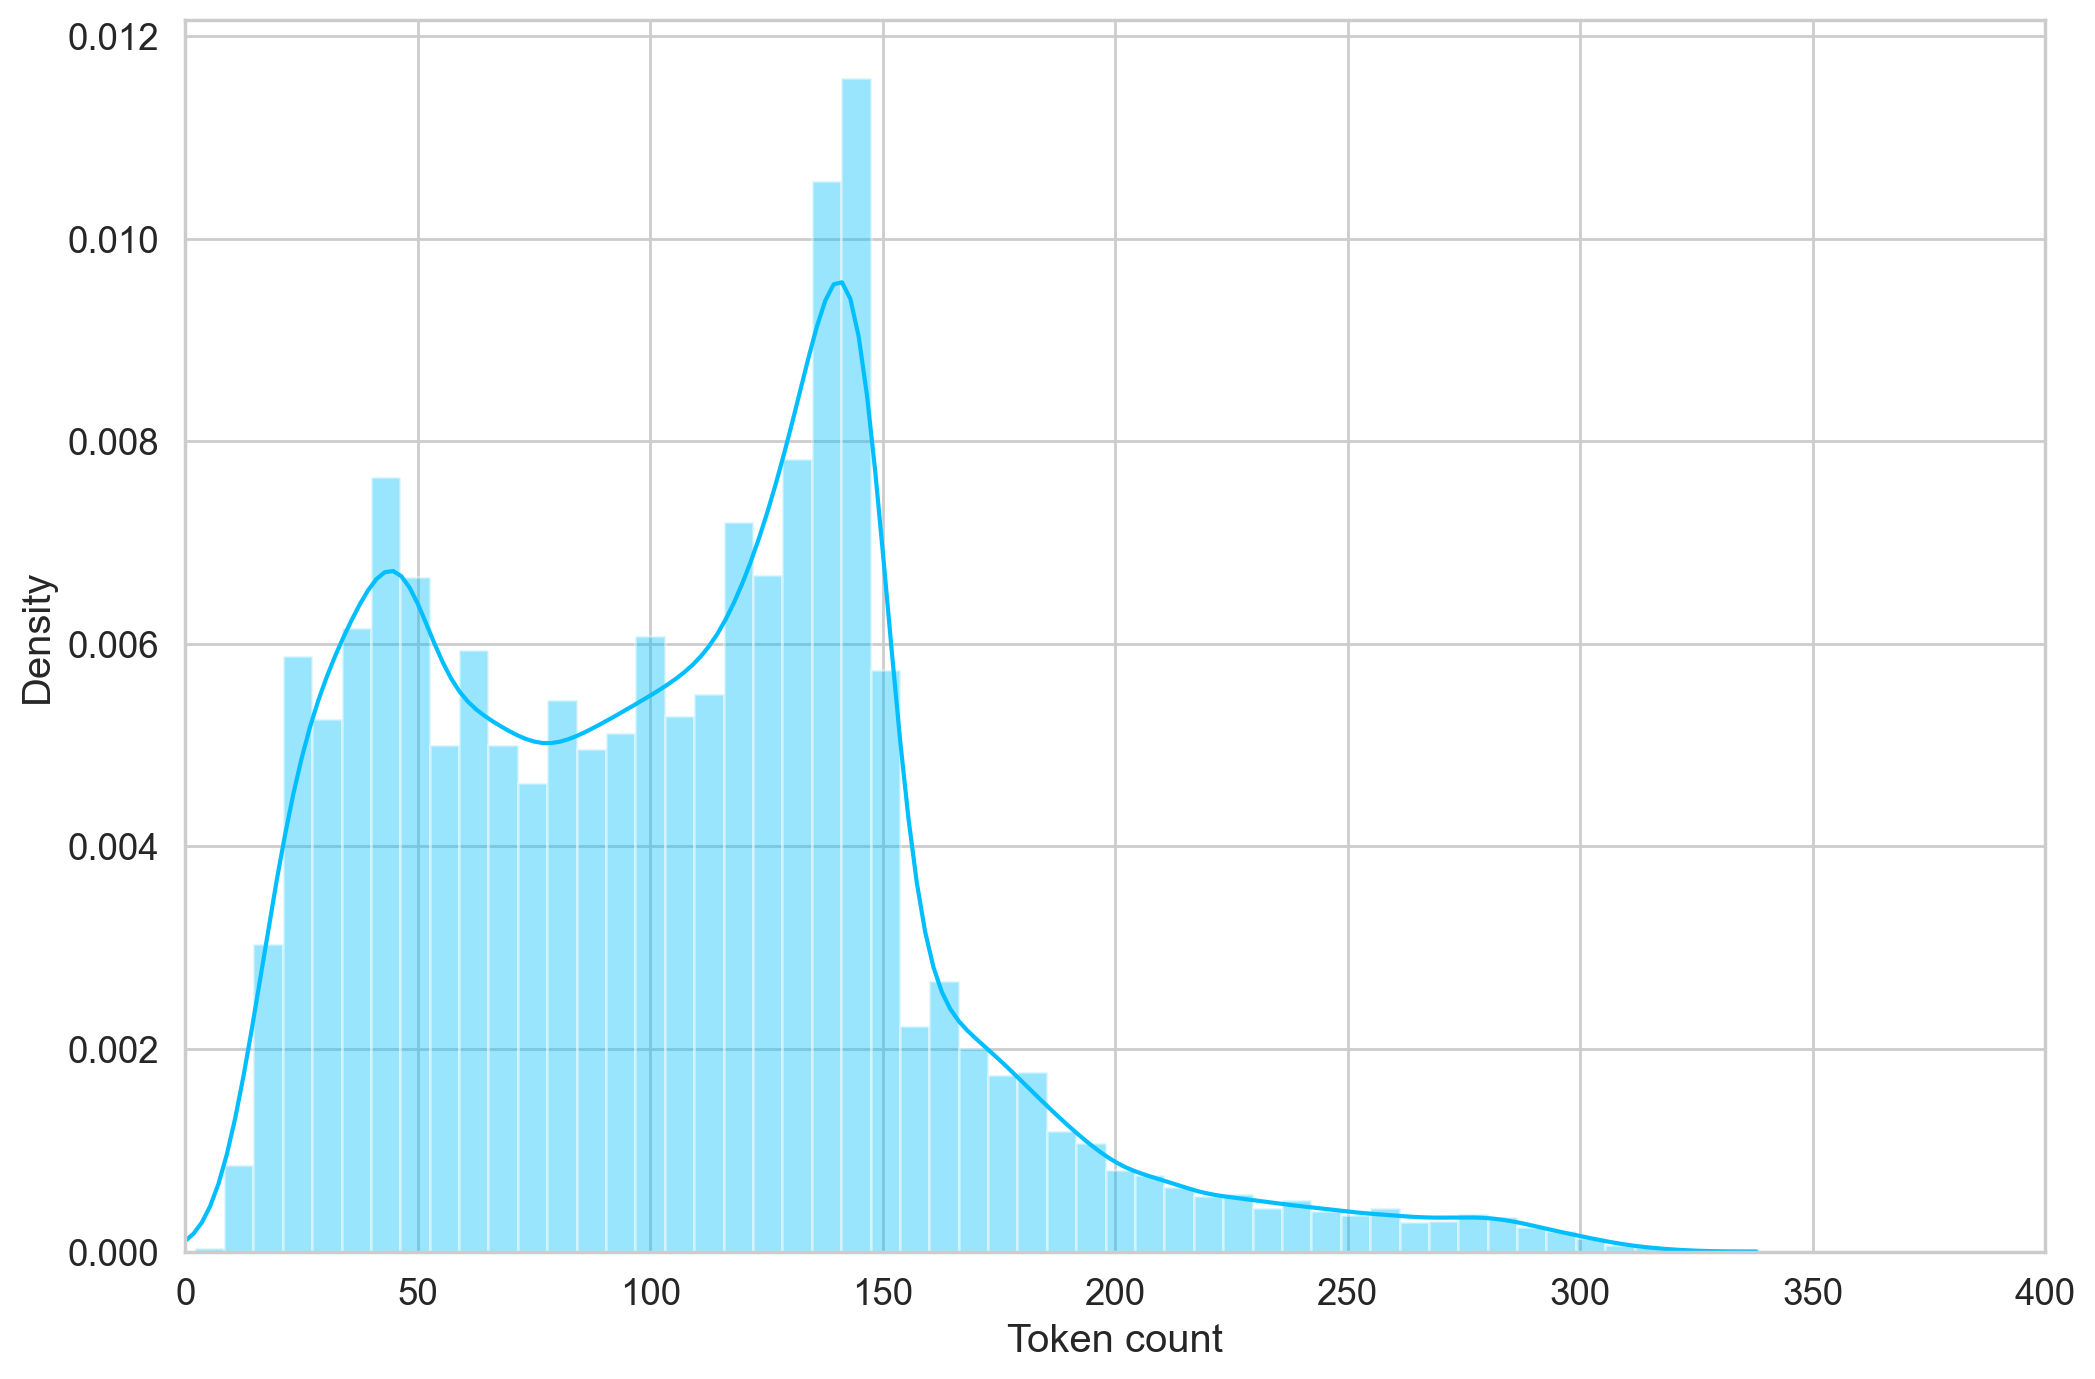

In [30]:
sns.distplot(token_lens)
plt.xlim([0, 400]);
plt.xlabel('Token count');

In [31]:
MAX_LEN = 300

## 4 构建数据集

### 4.1 自定义数据集

In [32]:
class WeboDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_len):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,item):
        """
        item 为数据索引，迭代取第item条数据
        """
        text=str(self.texts[item])
        label=self.labels[item]
        
        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
#         print(encoding['input_ids'])
        return {
            'texts':text,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'labels':torch.tensor(label,dtype=torch.long)
        }
        

### 4.2 划分数据集并创建生成器

In [39]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((30056, 2), (3757, 2), (3758, 2))

In [40]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=WeboDataset(
        texts=df['text'].values,
        labels=df['label'].values,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
#         num_workers=4 # windows多线程
    )

In [41]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [42]:
next(iter(train_data_loader))

D:\anaconda\envs\pytorch_gpu\lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'texts': ['扭秧歌爱推荐产品设计：隐形相机这是有韩国设计师带来的空气相机，它抛弃了相机的多余部分，只包含了2个银色指环：1个是装有蓝牙功能的拍摄镜头，另1个则是可感应手指动作的快门键。食指和拇指弯成方正的形，即拍照模式。弯成椭圆的形，切换摄像模式。拍下的影响同步到智能手机中。标签：',
  ' 这位网友您好：1、进口商品价格下降，刺激国内消费需求，这对商品零售业是个利好 2、出口商品竞争力下降，出口导向型企业转为以国内市场为主，同样会刺激国内消费需求。 3、人民币过度升值会导致消费者信心下降，对商品零售业也会造成一定的损害。 操作时应当逢低介入，长期持有。$LOTOzf$      唯一耗耗:分析师人气大赛 陈旭-宏源证券 老师您好，请问人民币升值是否会给商贸零售行业带来冲击呢？应该在操作时注意些什么？',
  '关于退房潮，有人指责国人没有契约精神。其实，不妨问问哪个房盘没有土地、规划、面积、配套设施等等的问题，这些方面开发商有没有诚信，有没有违约？再问问，法院最近还受理退房这种“敏感”案子吗？脱离了现实背景，谈抽象的契约精神，有意思吗？$LOTOzf$',
  '火影更新至461，462预告开始分享视频[火影忍者][461][卡卡西 我永远的对手] http:url.cn/4qkqF                收起[火影忍者][461][卡卡西 我永远的对手]$LOTOzf$'],
 'input_ids': tensor([[ 101, 2814, 4913,  ...,    0,    0,    0],
         [ 101, 6821,  855,  ...,    0,    0,    0],
         [ 101, 1068,  754,  ...,    0,    0,    0],
         [ 101, 4125, 2512,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 '

In [43]:
data_ = next(iter(train_data_loader))
data_.keys()

D:\anaconda\envs\pytorch_gpu\lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['texts', 'input_ids', 'attention_mask', 'labels'])

In [44]:
print(data_['input_ids'].shape)
print(data_['attention_mask'].shape)
print(data_['labels'].shape)

torch.Size([4, 300])
torch.Size([4, 300])
torch.Size([4])


## 5 文本多分类模型构建

In [45]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [47]:
df_test

,text,label
19399,转发微博阿童木童先生：福州聚划算，赶紧来团购啦免费配送仅83元抢购原价120元的杂志铺半年刊...,11
30070,【2店通用】仅售820元！价值1500元的孙建国音乐教育机构SUN音乐课寒假班（共10节课，...,19
22367,广州车展2012款瑞鹰1.9CTI柴油四驱版将正式对外发布，与老款车型相比，2012款柴油版...,15
31235,空间日志11月10日每日功课:突破区间，非美弱势回落 http:url.cn/0g4BGx$...,20
18082,:小:我又接到电话，不过我不是惠经噶:宅菜毛毛虫:去年我被骗了1000快啦惠经又有学生接到自...,10
...,...,...
18760,悉尼大学推出最新留学生实习计划提升就业能力:,10
2299,重大升级，将由DZ7.2一次性升级至DZX2.0。当前进展顺利，bbs数据转换已过半，可望...,0
9282,我要韵容焕肤化妆水，大家要支持我哦爱美丽爱服装爱购物摄影时尚街拍爱美丽爱时尚经典时尚大杂烩全...,6
19027,嘿汀汀章月新东方前途出国留学：华盛顿学者奖学金明年扩招中国学生在美国首都当政府实习生，今年开...,10


In [48]:
encoding = tokenizer.encode_plus(
            df_train.text[0],
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

D:\anaconda\envs\pytorch_gpu\lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [49]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask'],
    return_dict = False
)

In [50]:
last_hidden_state # 每个token的向量表示

tensor([[[ 0.9471,  0.2848,  0.0198,  ...,  0.9920,  0.9341, -0.3956],
         [ 0.6537,  0.8963,  1.4715,  ..., -0.4254,  0.8666,  0.2294],
         [ 1.7690,  0.9552,  0.7358,  ...,  0.8931,  0.9117,  1.2268],
         ...,
         [ 0.0069,  0.1872, -0.0316,  ..., -0.1039,  0.2316, -0.4533],
         [ 0.1530,  0.1277, -0.2187,  ..., -0.1595,  0.1672, -0.4335],
         [-0.0520,  0.1522, -0.1266,  ..., -0.1837,  0.2156, -0.4139]]],
       grad_fn=<NativeLayerNormBackward0>)

In [52]:
pooled_output

tensor([[ 0.9843,  0.9993,  0.9656, -0.0012,  0.6921,  0.5728,  0.0896,  0.1313,
          0.9352, -0.9260,  1.0000,  0.9667,  0.1972, -0.9280,  1.0000, -0.9969,
          0.1239,  0.8951,  0.9476, -0.6931,  0.9972, -1.0000, -0.8343, -0.9199,
          0.3934,  0.9267, -0.0555,  0.1025, -0.9999,  0.9761, -0.8906,  0.9986,
          0.8313, -0.9999, -0.9997,  0.8600, -0.9272,  0.9958, -0.9371, -0.0890,
         -0.9578, -0.9245,  0.6027, -0.6561, -0.9566,  0.9473, -1.0000, -0.8295,
          0.9686,  0.9989, -0.2584, -0.9971,  0.6066, -0.7638, -0.9943,  0.9965,
         -0.9908,  0.9598,  1.0000, -0.2124,  0.9988, -0.9392,  0.4834, -0.9977,
          1.0000, -0.9941, -0.8542,  0.2479,  0.9995,  0.9998, -0.5902,  0.9510,
          0.9998,  0.8982,  0.9839,  0.9625, -0.9522,  0.2565, -0.9998,  0.5960,
          1.0000,  0.8891,  0.8856, -0.9314,  0.0949, -0.9994, -0.9935,  0.9122,
          0.3579,  0.9701,  0.9971, -0.9966, -1.0000,  0.9347, -0.9973,  0.6522,
         -0.6274,  0.8922,  

In [53]:
last_hidden_state.shape

torch.Size([1, 300, 768])

In [54]:
pooled_output.shape

torch.Size([1, 768])

In [55]:
bert_model.config.hidden_size

768

In [62]:
pooled_output.shape
# 整体句子表示

torch.Size([1, 768])

In [56]:
class WeBoTextClassifier(nn.Module):
    def __init__(self, n_classes):
        super(WeBoTextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        output = self.drop(pooled_output) # dropout
        return self.out(output)

In [57]:
class_names=list(np.arange(21))
class_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [58]:
model = WeBoTextClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
data_

{'texts': ['扭秧歌爱推荐产品设计：隐形相机这是有韩国设计师带来的空气相机，它抛弃了相机的多余部分，只包含了2个银色指环：1个是装有蓝牙功能的拍摄镜头，另1个则是可感应手指动作的快门键。食指和拇指弯成方正的形，即拍照模式。弯成椭圆的形，切换摄像模式。拍下的影响同步到智能手机中。标签：',
  ' 这位网友您好：1、进口商品价格下降，刺激国内消费需求，这对商品零售业是个利好 2、出口商品竞争力下降，出口导向型企业转为以国内市场为主，同样会刺激国内消费需求。 3、人民币过度升值会导致消费者信心下降，对商品零售业也会造成一定的损害。 操作时应当逢低介入，长期持有。$LOTOzf$      唯一耗耗:分析师人气大赛 陈旭-宏源证券 老师您好，请问人民币升值是否会给商贸零售行业带来冲击呢？应该在操作时注意些什么？',
  '关于退房潮，有人指责国人没有契约精神。其实，不妨问问哪个房盘没有土地、规划、面积、配套设施等等的问题，这些方面开发商有没有诚信，有没有违约？再问问，法院最近还受理退房这种“敏感”案子吗？脱离了现实背景，谈抽象的契约精神，有意思吗？$LOTOzf$',
  '火影更新至461，462预告开始分享视频[火影忍者][461][卡卡西 我永远的对手] http:url.cn/4qkqF                收起[火影忍者][461][卡卡西 我永远的对手]$LOTOzf$'],
 'input_ids': tensor([[ 101, 2814, 4913,  ...,    0,    0,    0],
         [ 101, 6821,  855,  ...,    0,    0,    0],
         [ 101, 1068,  754,  ...,    0,    0,    0],
         [ 101, 4125, 2512,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 '

In [61]:
input_ids = data_['input_ids'].to(device)
attention_mask = data_['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 300])
torch.Size([4, 300])


In [62]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0569, 0.0179, 0.0117, 0.0600, 0.0234, 0.0677, 0.0147, 0.0355, 0.0446,
         0.0505, 0.0244, 0.0124, 0.0174, 0.0220, 0.0646, 0.2667, 0.0317, 0.0228,
         0.0813, 0.0287, 0.0451],
        [0.0443, 0.0266, 0.0540, 0.0386, 0.0306, 0.1055, 0.0295, 0.0449, 0.0353,
         0.0748, 0.0474, 0.0475, 0.0190, 0.0293, 0.0298, 0.1036, 0.0448, 0.0507,
         0.0563, 0.0230, 0.0646],
        [0.0841, 0.0205, 0.0126, 0.0481, 0.0174, 0.0493, 0.0262, 0.0555, 0.0214,
         0.1116, 0.0763, 0.0147, 0.0170, 0.0220, 0.0587, 0.1464, 0.0414, 0.0280,
         0.0452, 0.0679, 0.0358],
        [0.0413, 0.0526, 0.0167, 0.0253, 0.0283, 0.0759, 0.0263, 0.0296, 0.0188,
         0.0408, 0.0597, 0.0341, 0.0158, 0.0176, 0.0363, 0.2719, 0.0507, 0.0270,
         0.0297, 0.0293, 0.0723]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## 7 模型训练

In [63]:
EPOCHS = 10 # 训练轮数

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(#学习率预热
  optimizer,
  num_warmup_steps=0,#设置初始预热步数为0，意味着从一开始最大逐渐降到0
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

D:\anaconda\envs\pytorch_gpu\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [64]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [65]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() # 验证预测模式

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [66]:

history = defaultdict(list) # 记录10轮loss和acc
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/10
----------


D:\anaconda\envs\pytorch_gpu\lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


RuntimeError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 2.00 GiB total capacity; 1.57 GiB already allocated; 0 bytes free; 1.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

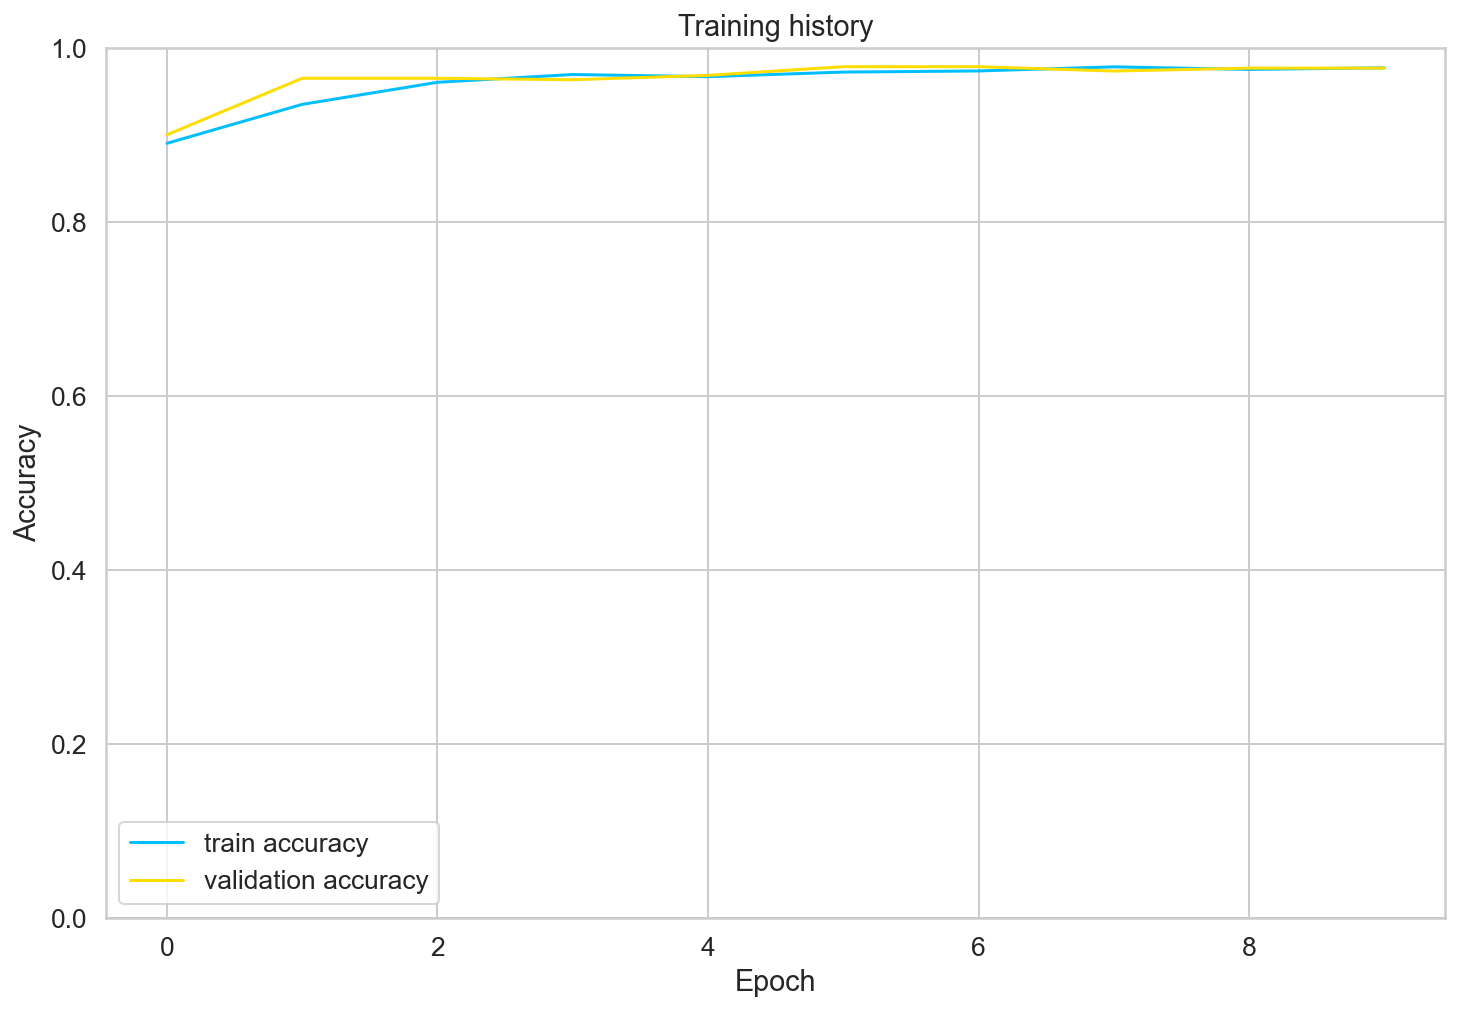

In [168]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# model = EnterpriseDangerClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## 8 模型评估

In [169]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9716666666666667

In [175]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["texts"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values


In [176]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [178]:
print(classification_report(y_test, y_pred, target_names=[str(label) for label in class_names]))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       554
           1       0.81      0.83      0.82        46

    accuracy                           0.97       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.97      0.97      0.97       600



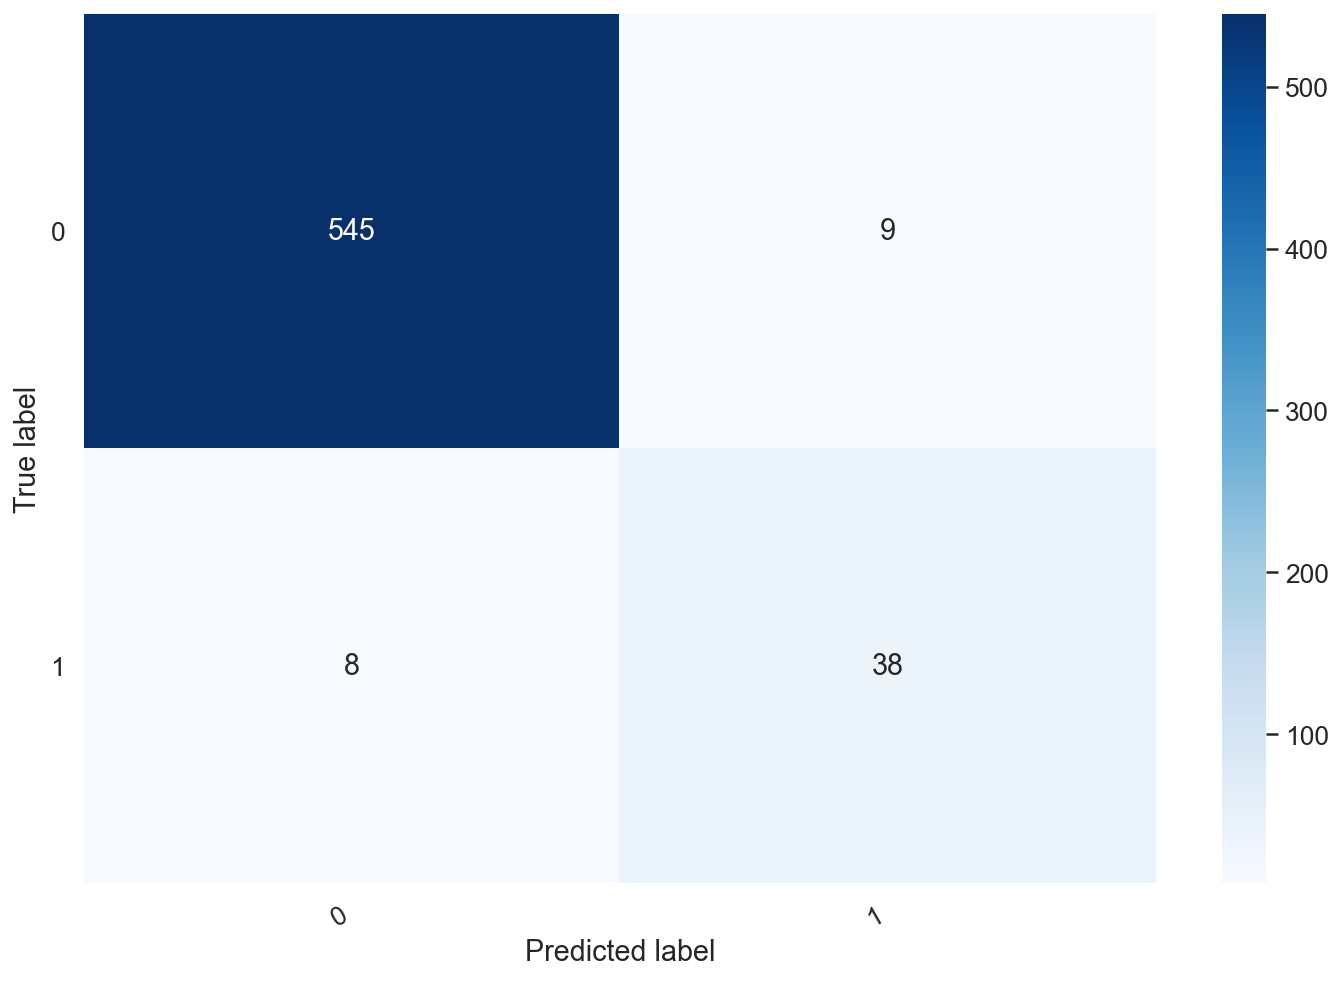

In [179]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


In [180]:
idx = 2

sample_text = y_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [181]:
print("\n".join(wrap(sample_text)))
print()
print(f'True label: {class_names[true_label]}')

焊锡员工未佩戴防护口罩 工业/危化品类 主要负责人、分管负责人及管理人员履职情况 分管负责人履职情况
分管负责人依法履行安全管理职责（存在职业健康危害的单位需自查职业卫生履职情况）。

True label: 0


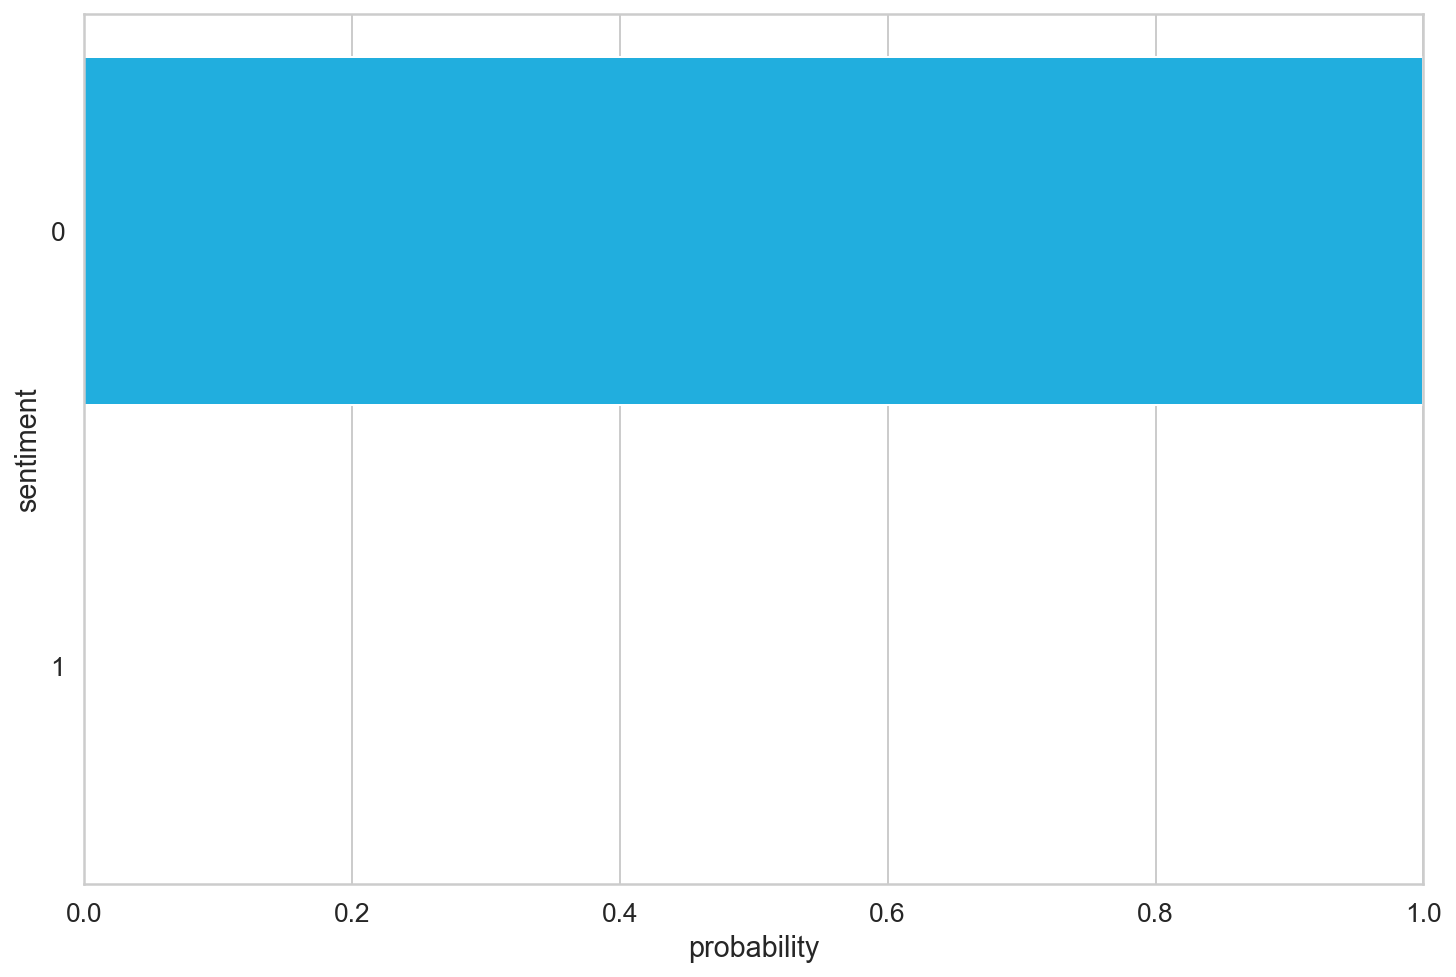

In [182]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## 9 测试集预测

In [187]:
sample_text = "“武汉嘉年华”武汉动漫十年盛典圆满成功12月24日漫展还会现场派发《淘漫画》、《最推理》、《穿越》三本杂志 "

In [188]:
encoded_text = tokenizer.encode_plus(
  sample_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [189]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sample text: {sample_text}')
print(f'Danger label  : {class_names[prediction]}')

Sample text: 电源插头应按规定正确接线
Danger label  : 1
